# Sentiment analysis of NER extacted sentences from short stories


In [52]:
!pip install tensorflow-gpu torch pandas numpy scikit-learn transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### I/O device registering

Current working directory is set to `/content` by default. You can also give access to your Google Drive to save models/results/... there.

In [53]:
from google.colab import drive
drive.mount("/content/drive/")

# Access your Drive data using folder '/content/drive/MyDrive'

!ls -lah /content/drive/MyDrive/NLP-Project/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
total 8.0K
drwx------ 3 root root 4.0K May  4 10:34 data
drwx------ 2 root root 4.0K May  4 10:35 ner


### GPU device selection review

You can directly use system command `nvidia-smi` or use Python library (e.g. Tensorflow or PyTorch) to check this.

In [54]:
!nvidia-smi

Tue May 24 21:45:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |   8274MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [55]:
import tensorflow as tf
import os
print(f"Tensorflow version: {tf.__version__}")

# Restrict TensorFlow to only allocate 4GBs of memory on the first GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(f"The system contains '{len(gpus)}' Physical GPUs and '{len(logical_gpus)}' Logical GPUs")
  except RuntimeError as e:
    print(e)
else:
    print(f"Your system does not contain a GPU that could be used by Tensorflow!")

Tensorflow version: 2.9.1
The system contains '1' Physical GPUs and '1' Logical GPUs


## Sentiment analysis

Using the sentances grouped by NER tagging. We calculate the normalised average of a persons sentiment.

For the sentiment analysis we are using the Huggingface siebert/sentiment-roberta-large-english model.

The model has been pretrained on various types of English text. Which is very important for sentiment classification performance in our usecase.

We run the sentiment analysis on 5 types of input data:
* without context (only the sentence where the NE is mentioned is analysed)
* following 3 (the three sentences following the immediate sentence are used as well)
* following 5
* preceding 3 (the three sentences preceeding the immediate sentence are used as well)
* preceeding 5
* combined (preceeding 3 + immediate + following 5)


In [56]:
# Imports
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from pathlib import PurePath
from matplotlib.collections import PatchCollection


In [128]:
# Character object

class CharacterData:
  def __init__(self, character, frequency, appearances):
    self.character = character
    self.frequency = int(frequency)
    self.appearances = appearances
    self.appearances_scores = []
    self.analysis_avg_scores = []
    self.sentiment_class = None
    self.sentiment_score = None
    self.status = ""

  def get_info(self):
    return self.character, self.frequency, self.sentiment_class, self.sentiment_score, self.status

  def print_info(self):
    print(f"{'':->150}")
    print(f"Character name: {self.character}")
    print(f"Frequency in story: {self.frequency}")
    if self.sentiment_class:
      print(f"Classified as {self.sentiment_class} with average score of: {self.sentiment_score}")
    print(f"{'':->150}")

  def get_appearances(self):
    return self.appearances

  def add_appearances_score(self, appearances_score):
    self.appearances_scores.append(appearances_score)
    #if len(self.appearances_scores) == len(self.appearances):
    #  self.calculate_statistics()

  def set_status(self):
    # Status of character P - protagonist, A - antagonist, "" - person
    if self.sentiment_class == "NEGATIVE":
      self.status = "A"
    elif self.sentiment_class == "POSITIVE":
      self.status = "P"

  def calculate_statistics(self, mode = "Average", analysis_type = 0):
    # Initialize the analysis result variable
    appearances_len = len(self.appearances)
    self.analysis_avg_scores = [{"NEGATIVE": 0, "POSITIVE": 0} for _ in range(6)]
    if mode == "Average": # Calculate the average negative and positive score for a character
      for score_batch in self.appearances_scores:
        for analysis_id, score in enumerate(score_batch): # Do the calculation for all the analysis types
            self.analysis_avg_scores[analysis_id][score["label"]] += float(score["score"]) / appearances_len

    # Set the global classification based on the manually selectetd analysis_type
    negative_score = self.analysis_avg_scores[analysis_type]["NEGATIVE"]
    positive_score = self.analysis_avg_scores[analysis_type]["POSITIVE"]

    if negative_score > positive_score:
      self.sentiment_class = "NEGATIVE"
      self.sentiment_score = negative_score
    elif negative_score == positive_score:
      self.sentiment_class = "RANDOM"
      self.sentiment_score = 0.5
    else:
      self.sentiment_class = "POSITIVE"
      self.sentiment_score = positive_score
      
    #elif mode == "Mean":
    #  negative_weighted_average = 0
    #  positive_weighted_average = 0
    #  sum_of_negative_scores = 0
    #  sum_of_positive_scores = 0
    #  for score in self.appearances_scores:
    #    if score["label"] == "NEGATIVE":
    #      negative_weighted_average += float(score["score"]) * 1
    #      sum_of_negative_scores += float(score["score"])
    #    elif score["label"] == "POSITIVE":
    #      positive_weighted_average += float(score["score"]) * 1
    #      sum_of_positive_scores += float(score["score"])
    #    else:
    #      raise ValueError("Label unknown!")

    #  # Calculate the mean
    #  if sum_of_negative_scores != 0:
    #    negative_weighted_average /= sum_of_negative_scores
    #  if sum_of_positive_scores != 0:
    #    positive_weighted_average /= sum_of_positive_scores

    #  if negative_weighted_average >= positive_weighted_average:
    #    self.sentiment_class = "NEGATIVE"
    #    self.sentiment_score = negative_weighted_average
    #  else:
    #    self.sentiment_class = "POSITIVE"
    #    self.sentiment_score = positive_weighted_average

  def get_highest_avg_score(self):
    max_score = 0
    max_id = 0
    for id, avg_score_by_analysis in enumerate(self.analysis_avg_scores):
      for score in avg_score_by_analysis.values():
        if score > max_score:
          max_score = score
          max_id = id

    return max_id, max_score

  def get_dict(self):
    return {
        "character": self.character,
        "frequency": self.frequency,
        "appearances": self.appearances,
        "appearances_scores": self.appearances_scores,
        "analysis_avg_scores": self.analysis_avg_scores,
        "sentiment_class": self.sentiment_class,
        "sentiment_score": self.sentiment_score
    }


In [129]:
# Read in the data

def decode_data(path, filename):
  # Output placeholder  
  story_data = []
  # Read the file
  with open(PurePath(path, filename)) as f:
    data = json.loads(f.read())
    #print(data)
    for character in data:
      if int(character["frequency"]) != 0:
        story_data.append(CharacterData(character["character"], character["frequency"], character["appearances"]))

  return story_data

# Write out the data

def encode_data(path, filename, output):
  # Export the json file
  json_dump = json.dumps(output)

  with open(PurePath(path, "sentiment", filename), "w") as f:
    f.write(json_dump)

In [130]:
# Sentiment pipeline

def sentiment_analysis(classifier, character_data):
  for appearances in character_data.get_appearances():
    #print(appearances)

    resulting_scores = []
    # Run the analysis on the immediate sentence
    inputs = [appearances["immediate"]]
    # Forward 3
    inputs += [" ".join(appearances["immediate"] + appearances["following5"][:3])]
    # Forward 5
    inputs += [" ".join(appearances["immediate"] + appearances["following5"])]
    # Preceeding 3
    inputs += [" ".join(appearances["preceeding5"][:3] + appearances["immediate"])]
    # Preceeding 5
    inputs += [" ".join(appearances["preceeding5"] + appearances["immediate"])]
    # Preceeding 3 + immediate + Forward 5
    inputs += [" ".join(appearances["preceeding5"][:3] + appearances["immediate"] + appearances["following5"])]
    for input in inputs:
      resulting_scores.extend(classifier(input))

    # Add the score to the character_data
    character_data.add_appearances_score(resulting_scores)


In [131]:
# Plot the data

def label(xy, text):
    y = xy[1] - 0.15  # Shift y-value for label so that it's below the NE
    plt.text(xy[0], y, text, ha="center", family='sans-serif', size=14)

def plot_data(story_data):
  fig, ax = plt.subplots()
  # Create 2x2 grid to plot the artists
  grid = np.mgrid[0.2:0.8:2j, 0.2:0.8:2j].reshape(2, -1).T
  
  patches = []
  colors = []

  for i, character in enumerate(story_data):
    name, freq, sentiment, score, status = character.get_info()

    color = "g"
    if sentiment == "NEGATIVE":
      color = "r"

    # Add a circle
    circle = mpatches.Circle(grid[i], 0.1, ec = "none", color = color)
    patches.append(circle)
    label(grid[i], f"{name} - {status} ({score:.2f})")

  collection = PatchCollection(patches, match_original = True)
  ax.add_collection(collection)

  plt.axis('equal')
  plt.axis('off')
  plt.tight_layout()

  plt.show()

In [135]:
# Main execution

def main(path, stories):
  # Select the device to run the model on
  device = 0 if torch.cuda.is_available() else "cpu"
  # Select the model
  model_name = "siebert/sentiment-roberta-large-english"
  model = AutoModelForSequenceClassification.from_pretrained(model_name)
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  path_ner = PurePath(path, "ner")

  for file in os.listdir(path_ner):
    if os.path.isfile(PurePath(path_ner, file)):
      filename = PurePath(file)

      print(f"{'':_>150}")
      print(filename)
      print(f"{'':_>150}\n")

      # Get the data
      story_data = decode_data(path_ner, filename)
      #print(story_data)
      
      # Sentiment analysis pipeline
      classifier = pipeline("sentiment-analysis", model = model, tokenizer = tokenizer, device = device, max_length = 512, truncation = True)

      # Placeholder for output
      output = []

      # Run sentiment analysis for all the characters in the story
      for count, character_data in enumerate(story_data):
        character_data.print_info()
        print("Running sentiment analysis...")
        sentiment_analysis(classifier, character_data)

        # Calculate the statistics
        character_data.calculate_statistics("Average", 5) # Using the Forward 5 for the final classification

        if count < 2:
          character_data.set_status();

        character_data.print_info()

        # Add data to output
        output.append(character_data.get_dict())

      # Add to stories
      stories[filename] = story_data

      # Output to json
      encode_data(path, filename, output)

      # Plot the results
      plot_data(story_data)
    

In [136]:
# All the story data
stories = {}

# Summary for visualization
sentiment_confidence_by_context = [0] * 6 # Placeholder to vote for the highest sentiment score by type

______________________________________________________________________________________________________________________________________________________
Henry_Red_Chief.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: dorset
Frequency in story: 12
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...


/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: dorset
Frequency in story: 12
Classified as NEGATIVE with average score of: 0.6264758706092834
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: sam
Frequency in story: 12
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: sam
Frequency in story: 12
Classified as NEGA

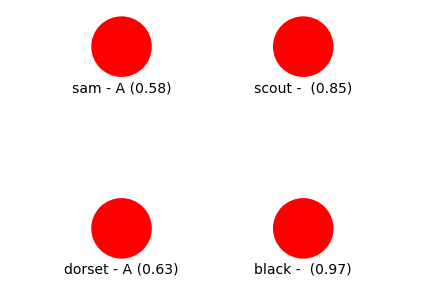

______________________________________________________________________________________________________________________________________________________
The Lady or the Tiger Original.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: frank
Frequency in story: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: frank
Frequency in story: 1
Classified as POSITIVE with average score of: 0.9918394088745117
-------------------------

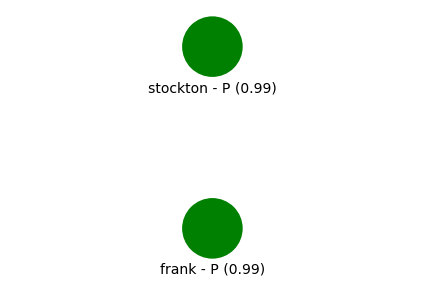

______________________________________________________________________________________________________________________________________________________
LeiningenVstheAnts.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: carl
Frequency in story: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: carl
Frequency in story: 1
Classified as POSITIVE with average score of: 0.9800812005996704
---------------------------------------

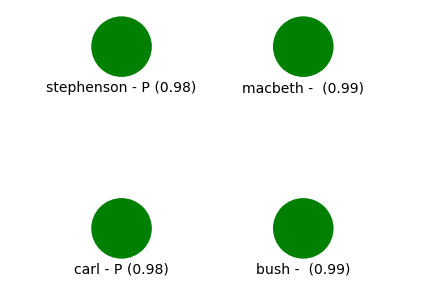

______________________________________________________________________________________________________________________________________________________
the_gift_of_the_magi_0_Henry.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: jim
Frequency in story: 30
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: jim
Frequency in story: 30
Classified as POSITIVE with average score of: 0.5320681379391597
-----------------------------

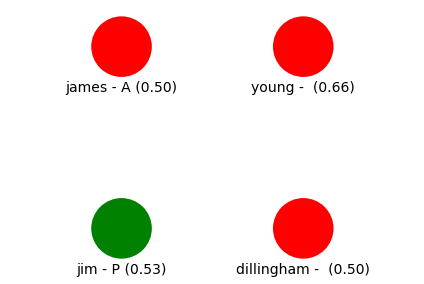

______________________________________________________________________________________________________________________________________________________
The Tell Tale Heart.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: edgar
Frequency in story: 1
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: edgar
Frequency in story: 1
Classified as POSITIVE with average score of: 0.9979514479637146
------------------------------------

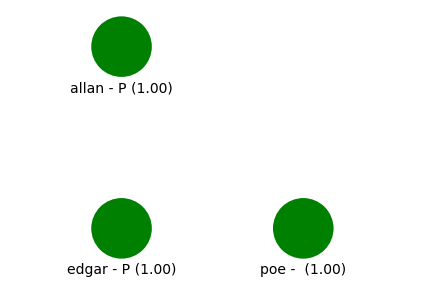

______________________________________________________________________________________________________________________________________________________
The Most Dangerous Game.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: rainsford
Frequency in story: 134
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: rainsford
Frequency in story: 134
Classified as NEGATIVE with average score of: 0.5093480825424196
--------------------

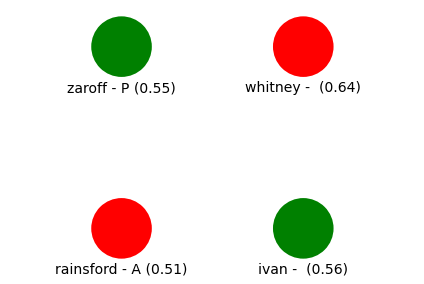

______________________________________________________________________________________________________________________________________________________
Hills Like White Elephants.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: ernest
Frequency in story: 2
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: ernest
Frequency in story: 2
Classified as POSITIVE with average score of: 0.49787113070487976
--------------------------

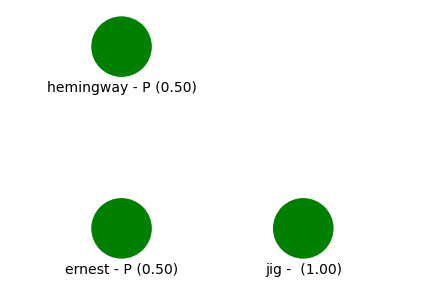

In [137]:
 # imapbook execution 
path = "/content/drive/MyDrive/NLP-Project/data/imapbook/"

main(path, stories)

______________________________________________________________________________________________________________________________________________________
Howard_TheDevilinIron.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: conan
Frequency in story: 76
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...


/usr/local/lib/python3.7/dist-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: conan
Frequency in story: 76
Classified as POSITIVE with average score of: 0.6938888618390856
------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: jehungir
Frequency in story: 30
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: jehungir
Frequency in story: 30
Classifie

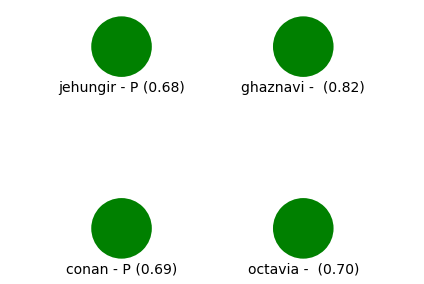

______________________________________________________________________________________________________________________________________________________
Howard_ShadowsintheMoonlight.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: conan
Frequency in story: 79
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: conan
Frequency in story: 79
Classified as POSITIVE with average score of: 0.6394703663312472
-------------------------

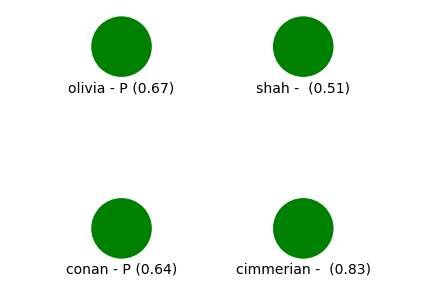

______________________________________________________________________________________________________________________________________________________
Howard_SchadowsinZamboula.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: conan
Frequency in story: 117
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: conan
Frequency in story: 117
Classified as POSITIVE with average score of: 0.5313084921960173
--------------------------

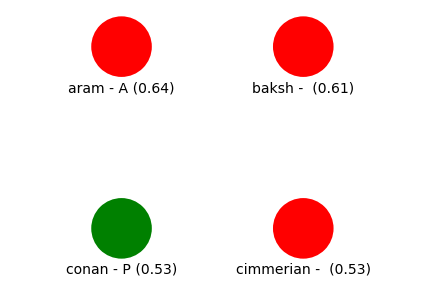

______________________________________________________________________________________________________________________________________________________
Doyle_TheSignoftheFour.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: holmes
Frequency in story: 135
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: holmes
Frequency in story: 135
Classified as POSITIVE with average score of: 0.5525881818362645
---------------------------

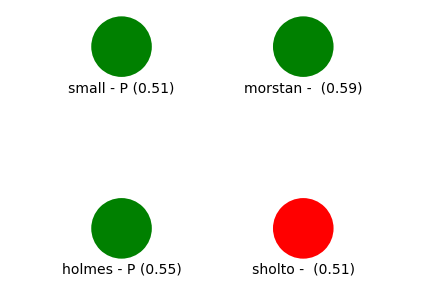

______________________________________________________________________________________________________________________________________________________
Kipling_TheJungleBook.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: little
Frequency in story: 231
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: little
Frequency in story: 231
Classified as POSITIVE with average score of: 0.5038613249722137
----------------------------

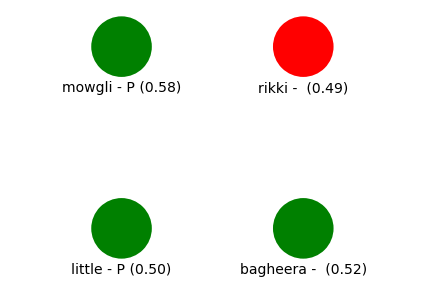

______________________________________________________________________________________________________________________________________________________
Doyle_TheHoundoftheBaskervilles.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: holmes
Frequency in story: 194
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: holmes
Frequency in story: 194
Classified as POSITIVE with average score of: 0.6033197685061947
------------------

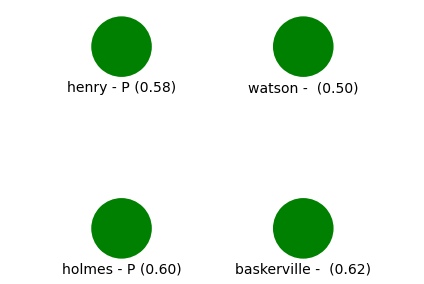

______________________________________________________________________________________________________________________________________________________
Lovecraft_TheCallofCthulu.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: old
Frequency in story: 31
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: old
Frequency in story: 31
Classified as POSITIVE with average score of: 0.6235437150354738
--------------------------------

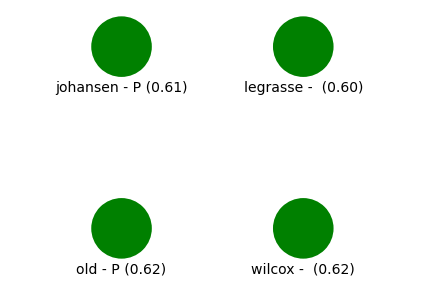

______________________________________________________________________________________________________________________________________________________
Lovecraft_TheShunnedHouse.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: harris
Frequency in story: 34
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: harris
Frequency in story: 34
Classified as POSITIVE with average score of: 0.6825601272284985
--------------------------

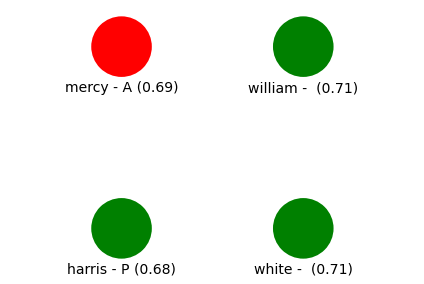

______________________________________________________________________________________________________________________________________________________
Doyle_AStudyinScarlet.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: holmes
Frequency in story: 97
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: holmes
Frequency in story: 97
Classified as POSITIVE with average score of: 0.6003264582034237
------------------------------

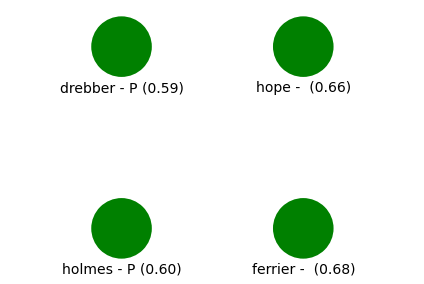

______________________________________________________________________________________________________________________________________________________
Kipling_ThyServantaDog.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: dog
Frequency in story: 152
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: dog
Frequency in story: 152
Classified as NEGATIVE with average score of: 0.571317922550699
----------------------------------

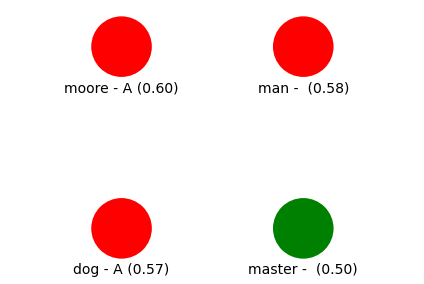

______________________________________________________________________________________________________________________________________________________
Lovecraft_AttheMountainofMadness.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: great
Frequency in story: 92
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: great
Frequency in story: 92
Classified as POSITIVE with average score of: 0.8463250906629997
---------------------

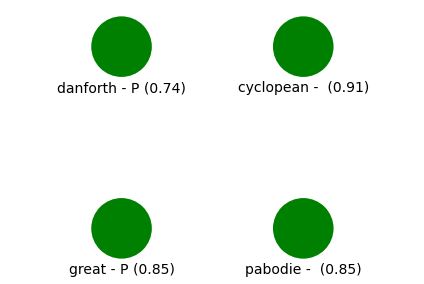

______________________________________________________________________________________________________________________________________________________
Kipling_TheEndofthePassage.json
______________________________________________________________________________________________________________________________________________________

------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: spurstow
Frequency in story: 61
------------------------------------------------------------------------------------------------------------------------------------------------------
Running sentiment analysis...
------------------------------------------------------------------------------------------------------------------------------------------------------
Character name: spurstow
Frequency in story: 61
Classified as NEGATIVE with average score of: 0.7784855534633001
---------------------

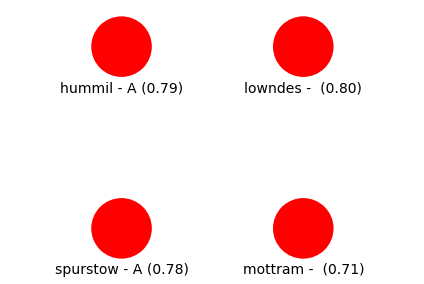

In [138]:
# gutenberg execution
path = "/content/drive/MyDrive/NLP-Project/data/gutenberg/"

main(path, stories)

Visualizing the most successful method of analysis:
[12, 12, 16, 5, 12, 15]


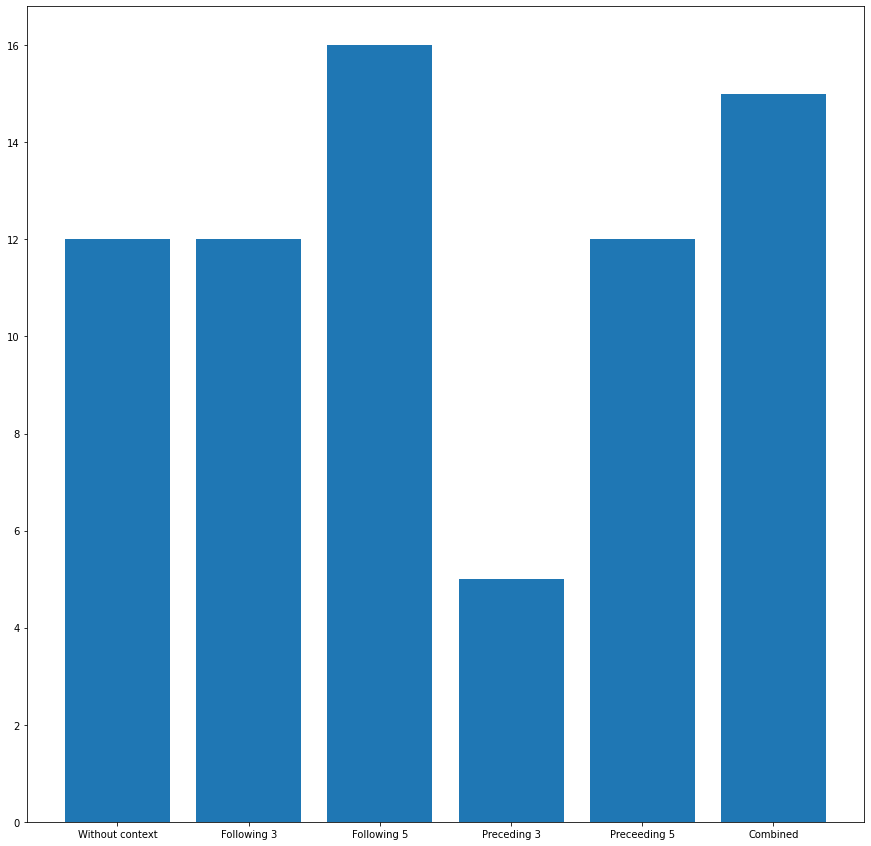

In [139]:
# Voting for the most vizualization of the highest analysis type
highest_avg_score_data = [character.get_highest_avg_score() for story in stories.values() for character in story]

for id, high_avg_sc in highest_avg_score_data:
  sentiment_confidence_by_context[id] += 1

print("Visualizing the most successful method of analysis:")
print(sentiment_confidence_by_context)

plt.figure(figsize = (15, 15))
plt.bar(list(range(6)), sentiment_confidence_by_context, tick_label = ["Without context", "Following 3", "Following 5", "Preceding 3", "Preceeding 5", "Combined"])
plt.show()


In [140]:
# Run this at the end

drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
